In [27]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qiskit_optimization.applications.vertex_cover import VertexCover
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 7]
%config InlineBackend.figure_format = 'retina'

In [17]:
data = pd.read_csv("./datasets/heroes/hero-network.csv")

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


In [19]:
data.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [20]:
heroes = [
 'MEDUSA/MEDUSALITH AM',
 'ARCLIGHT/PHILLIPA SO',
 'WOLVERINE/LOGAN ',
 'SCARLET WITCH/WANDA ',
 'ARAGORN',
 'OVERMIND/GROM',
 'BATTLEAXE/',
 'ION/',
 'PINK PEARL/'
]

In [21]:
relations = data[(data.hero1.isin(heroes)) & (data.hero2.isin(heroes))]
relations = pd.DataFrame(np.sort(relations.values, axis = 1), columns = relations.columns).drop_duplicates(subset = ['hero1', 'hero2'])

In [22]:
graph = nx.from_pandas_edgelist(relations, source = 'hero1', target = 'hero2')

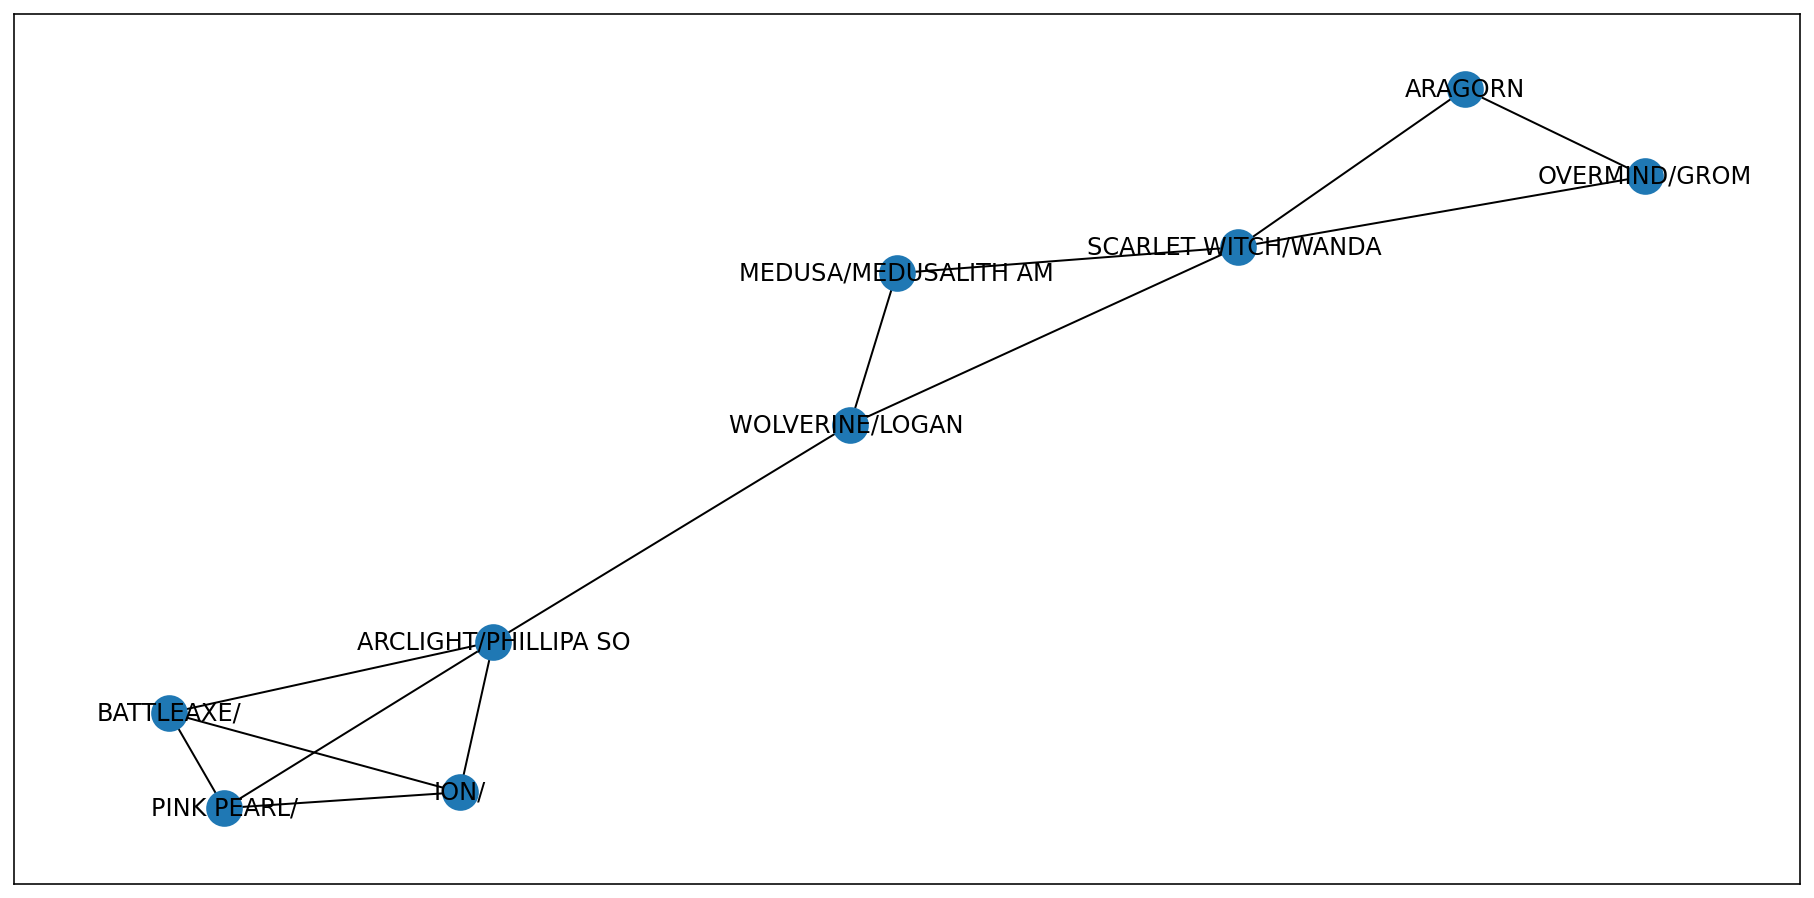

In [23]:
plt.figure(1, figsize = (16, 8))
nx.draw_networkx(graph)

In [24]:
matrix = nx.to_pandas_adjacency(graph, dtype = int)
adjacency = matrix.to_numpy()

In [26]:
vertex_cover = VertexCover(adjacency)

In [28]:
qp = vertex_cover.to_quadratic_program()

backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend)

qaoa = QAOA(reps = 3, quantum_instance = quantum_instance)
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

result = qaoa_optimizer.solve(qp)

In [30]:
print('solution:', vertex_cover.interpret(result))

solution: [0, 1, 3, 5, 6, 7]


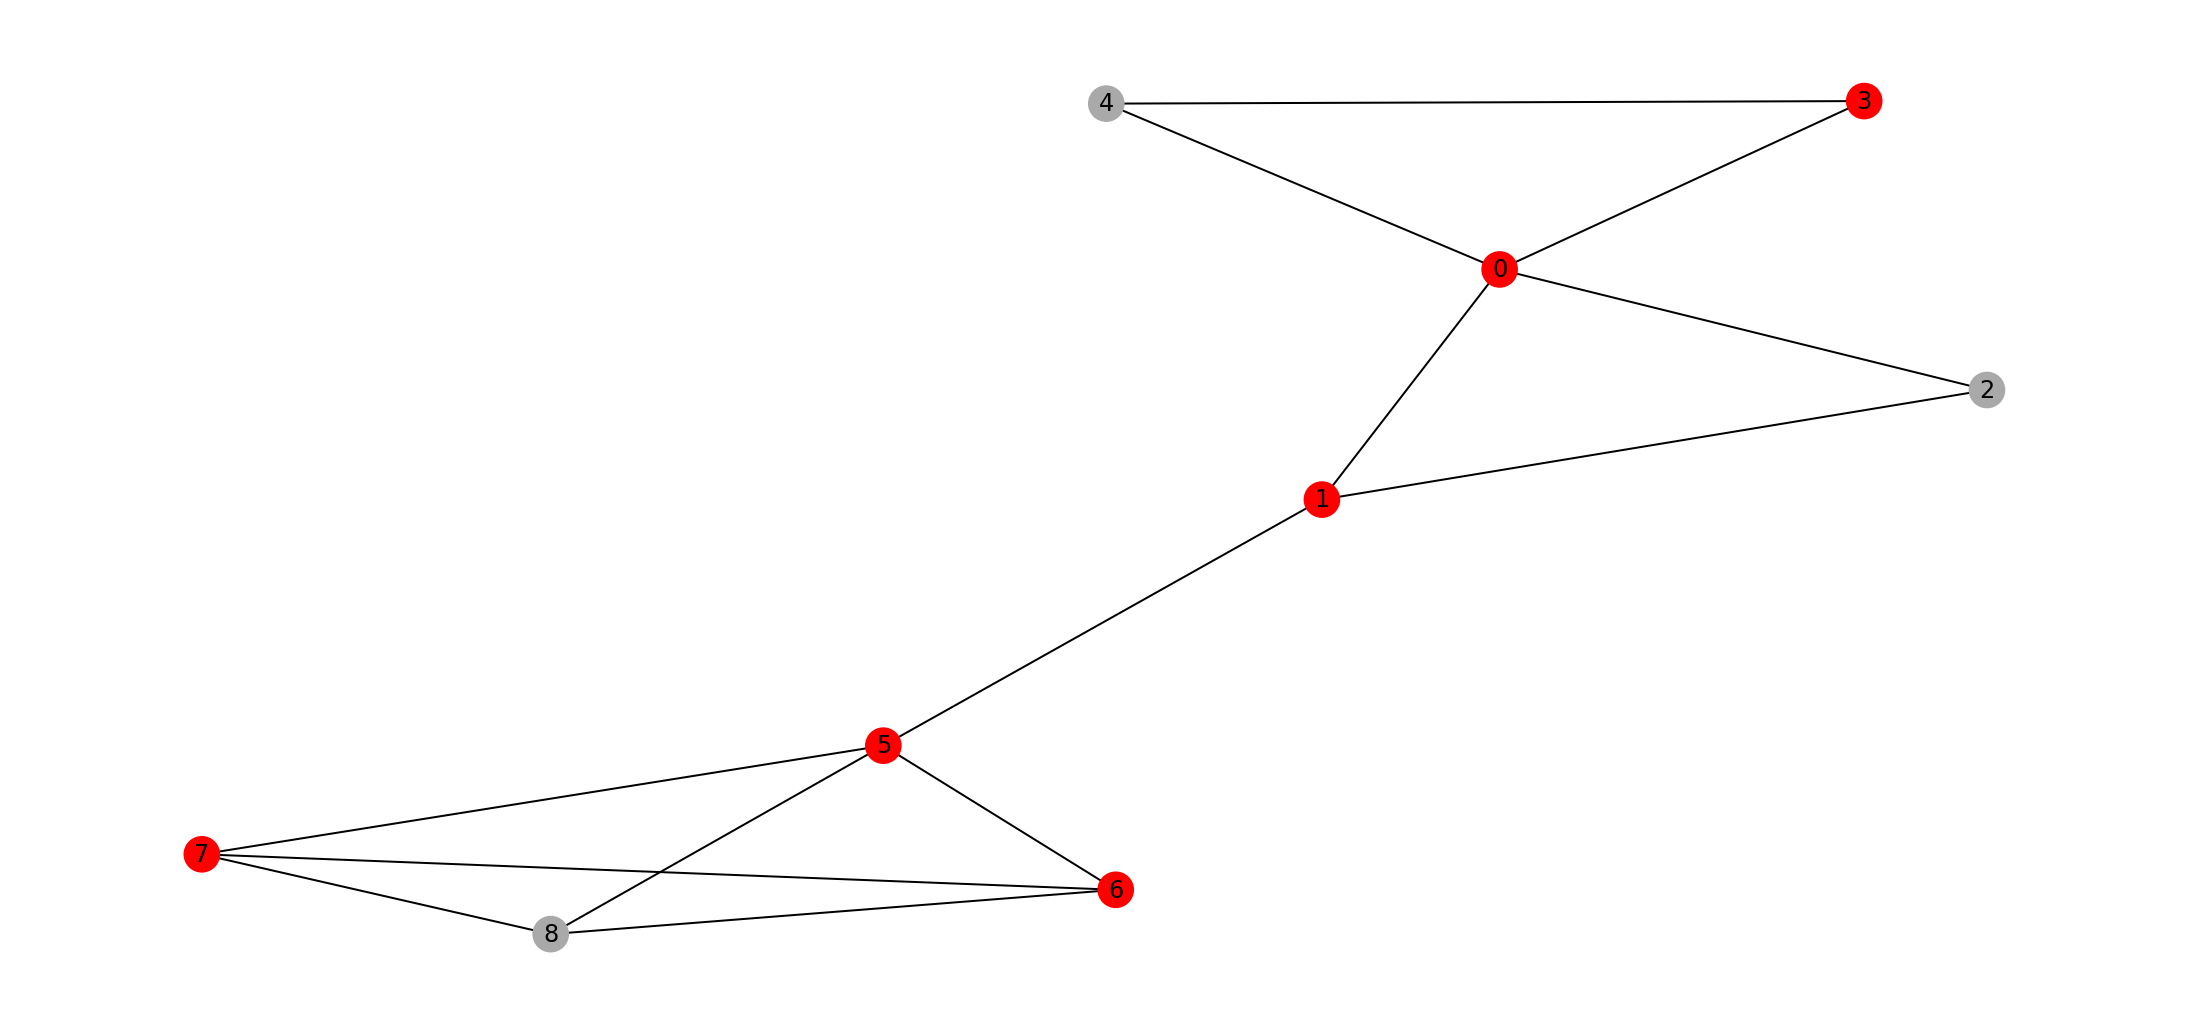

In [31]:
vertex_cover.draw(result)

#### Weighted Vertex Cover Problem

In [81]:
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model
from typing import List

class WeightedVertexCover(VertexCover):
    
    def to_quadratic_program(self) -> QuadraticProgram:
        
        mdl = Model(name ="Weighted Vertex Cover Problem")
        
        n = self._graph.number_of_nodes()
        x = {i: mdl.binary_var(name = f"x_{i}") for i in range(n)}
        
        nodes = dict(enumerate(self._graph.nodes))
        lnodes = list(self._graph.nodes)
        
        max_weight = max(self._graph.nodes[node]['weight'] for node in lnodes)
        
        for w, v in self._graph.edges:
            self._graph.edges[w, v].setdefault("weight", 1)
            
        objective = mdl.sum(x[i] * (max_weight - self._graph.nodes[nodes[i]]['weight']) for i in x)
        
        for w, v in self._graph.edges:
            mdl.add_constraint(x[lnodes.index(w)] + x[lnodes.index(v)] >= 1)
            
        mdl.minimize(objective)
        op = from_docplex_mp(mdl)
        return op
    
    def _node_colors(self, x: np.ndarray) -> List[str]:
        
        nodes = list(dict(enumerate(self._graph.nodes)).items())
        
        return ['r' if x[node[0]] else 'darkgrey' for node in nodes]

In [82]:
count_series1 = data.groupby(['hero1']).size()
count_series2 = data.groupby(['hero2']).size()

appearances = count_series1.add(count_series2, fill_value = 0)

In [83]:
for hero in heroes:
    graph.nodes[hero]['weight'] = appearances[hero]

In [84]:
weighted_vertex_cover = WeightedVertexCover(graph)

In [85]:
qp = weighted_vertex_cover.to_quadratic_program()

backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend)

qaoa = QAOA(reps = 2, quantum_instance = quantum_instance)
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

result = qaoa_optimizer.solve(qp)

In [86]:
print('solution:', vertex_cover.interpret(result))
print('time:', result.min_eigen_solver_result.optimizer_time)

solution: [0, 1, 3, 5, 7, 8]
time: 9.614149808883667


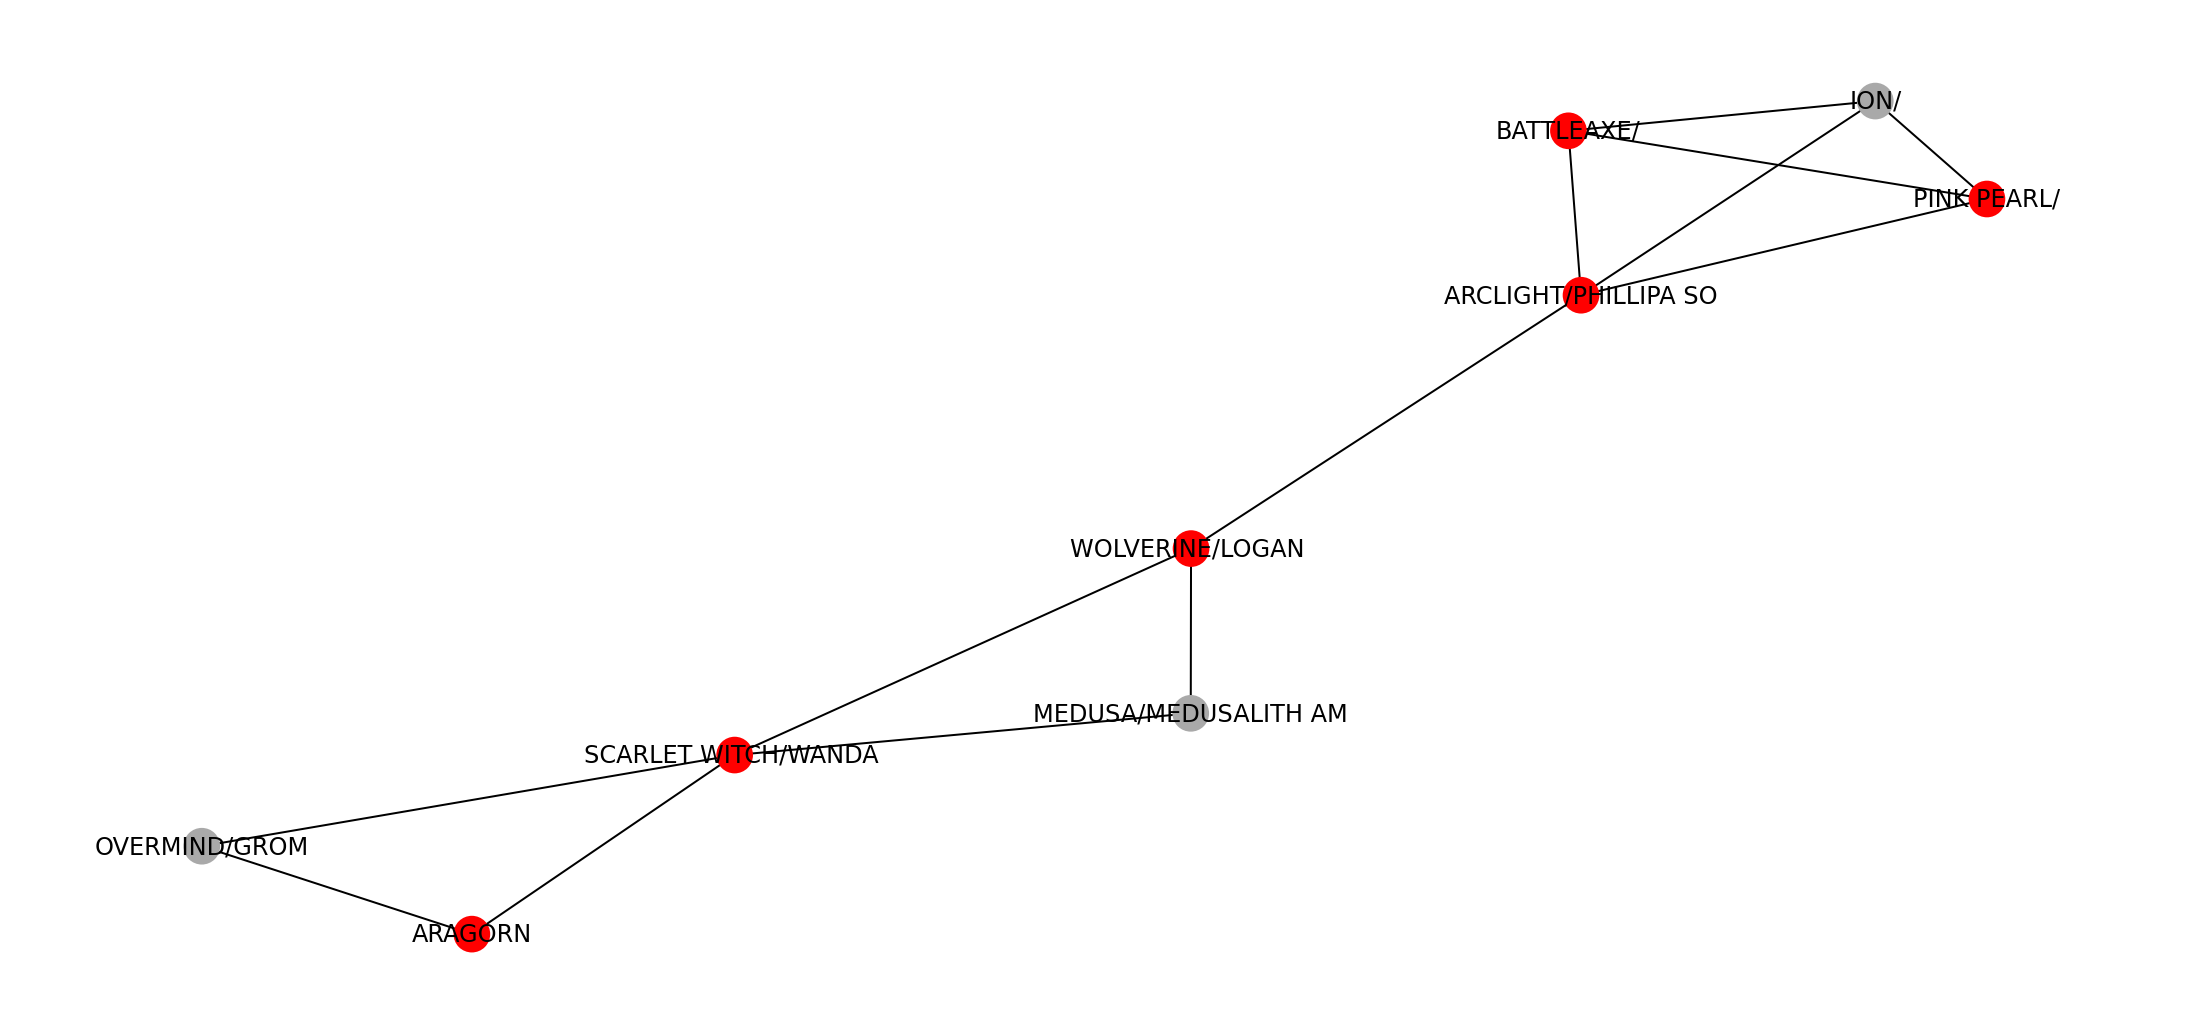

In [87]:
weighted_vertex_cover.draw(result)